In [1]:
import pandas as pd
import re
import struct
import matplotlib.pyplot as plt
import numpy as np
import sys
import os

from scipy.signal import find_peaks

import matplotlib.colors as mcolors

current_dir = '/home/marian/CIGAR_ANALYSIS/CIGAR/notebooks'

# Build the absolute path to ../functions
functions_path = os.path.abspath(os.path.join(current_dir, '../functions'))

# Add it to sys.path
sys.path.append(functions_path)

import parse_data 
import cigar as cig

from tqdm import tqdm


/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
colors = ['royalblue', 'crimson', 'black', 'green', 'darkorange', 'brown', 'coral', 'indigo', 'magenta', 'blue']


##  Data reading

In [3]:

start           = 1
nfiles          = 11


In [4]:
amp_factors = {'CH1':269,
               'CH2':267,
               'CH3':258,
               'CH4':275
               }

amplified   = True

temperature = 8 # [deg]
pressure    = 6.5 # [bar]

pes         = True

nchannels   = 10

# offline_trg = None
offline_trg = 'AND'
# offline_trg = 'Majority3'

In [5]:
data_nosource = {'source':'no-source',
                 'run':'Run27',
                 'nchannels': nchannels,
                 'nevents_per_wvf': 500,
                 'samples_per_waveform': 752,
                 'event_header_bytes': 28,
                 'sample_binning': 8e-9,
                 'integration_window_min':1.8e-6,
                 'integration_window_max':3e-6,
                 'temperature':f'{temperature}deg',
                 'is_amplified':amplified,
                 'amp_factors':amp_factors,
                 'pes':pes
                 }

run_nosource_dir     = f"/home/marian/CIGAR_ANALYSIS/CIGAR/data/{data_nosource['run']}"


In [6]:
data_source = {'source':'Ba133',
               'run':'Run28',
               'nchannels': nchannels,
               'nevents_per_wvf': 500,
               'samples_per_waveform': 752,
               'event_header_bytes': 28,
               'sample_binning': 8e-9,
               'integration_window_min':1.8e-6,
               'integration_window_max':3e-6,
               'temperature':f'{temperature}deg',
               'is_amplified':amplified,
               'amp_factors':amp_factors,
               'pes':pes
               }

run_source_dir     = f"/home/marian/CIGAR_ANALYSIS/CIGAR/data/{data_source['run']}"


In [7]:
parse_data.checkWfs(run_nosource_dir, 
                    1, 5, 
                    data_nosource['nchannels'], 
                    data_nosource['samples_per_waveform'], 
                    data_nosource['event_header_bytes'], 
                    print_headers = False
                    )

/home/marian/CIGAR_ANALYSIS/CIGAR/data/Run27
Waveforms shape: (500, 10, 752)
Waveforms shape: (500, 10, 752)
Waveforms shape: (500, 10, 752)
Waveforms shape: (500, 10, 752)


In [8]:
parse_data.checkWfs(run_source_dir, 
                    1, 5, 
                    data_source['nchannels'], 
                    data_source['samples_per_waveform'], 
                    data_source['event_header_bytes'], 
                    print_headers = False
                    )

/home/marian/CIGAR_ANALYSIS/CIGAR/data/Run28
Waveforms shape: (500, 10, 752)
Waveforms shape: (500, 10, 752)
Waveforms shape: (500, 10, 752)
Waveforms shape: (500, 10, 752)


In [9]:

# Initialize an empty list to store DataFrames
dataframes_nosource = []

# Loop through each folder and read all CSV files
for i, file in enumerate(tqdm(os.listdir(run_nosource_dir)[start:nfiles],desc=f"Reading {data_nosource['source']} .bin files", unit="file")):
    if file.endswith(".bin"):
        file_path = os.path.join(run_nosource_dir, file)
        df = parse_data.parse_wf_from_binary(file_path, 
                                             channels = data_nosource['nchannels'], 
                                             n_events = data_nosource['nevents_per_wvf'],
                                             file_idx = i,
                                             event_header_bytes = data_nosource['event_header_bytes'],
                                             sample_binning = data_nosource['sample_binning']
                                             )   
        dataframes_nosource.append(df)

Reading no-source .bin files: 100%|██████████| 10/10 [00:21<00:00,  2.16s/file]


In [10]:

# Initialize an empty list to store DataFrames
dataframes_source = []

# Loop through each folder and read all CSV files
for i, file in enumerate(tqdm(os.listdir(run_source_dir)[-nfiles:-start],desc=f"Reading {data_source['source']} .bin files", unit="files")):
    if file.endswith(".bin"):
        file_path = os.path.join(run_source_dir, file)
        df = parse_data.parse_wf_from_binary(file_path, 
                                            channels = data_source['nchannels'], 
                                            n_events = data_source['nevents_per_wvf'],
                                            file_idx = i,
                                            event_header_bytes = data_source['event_header_bytes'],
                                            sample_binning = data_source['sample_binning']
                                            )  
        dataframes_source.append(df)

Reading Ba133 .bin files: 100%|██████████| 10/10 [00:20<00:00,  2.09s/files]


In [11]:
# Merge all DataFrames into one
merged_df_source    = pd.concat(dataframes_source, ignore_index=True)
merged_df_nosource  = pd.concat(dataframes_nosource, ignore_index=True)

In [12]:
merged_df_source.tail()

,TIME,CH1,CH2,CH3,CH4,CH5,CH6,CH7,CH8,CH9,CH10,event,event_time,file_idx
3759995,0.000006,2.633449,3.187912,-370.053131,-488.515472,-410.200134,-646.604126,-350.097351,-591.882751,-409.006592,-560.725952,4999,149186631821,9
3759996,0.000006,2.817178,2.636158,-369.807373,-495.083008,-410.691681,-643.414612,-350.035980,-591.085388,-408.883545,-551.828491,4999,149186631821,9
3759997,0.000006,2.755935,2.758770,-369.807373,-499.747833,-410.384491,-643.353333,-350.588196,-592.925415,-409.006592,-547.962646,4999,149186631821,9
3759998,0.000006,2.939664,2.636158,-369.684479,-502.816772,-410.200134,-645.009399,-350.833618,-598.752258,-408.883545,-547.410400,4999,149186631821,9
3759999,0.000006,2.633449,2.881382,-369.745911,-502.325745,-409.954376,-643.107971,-351.447174,-605.499146,-409.191132,-549.189880,4999,149186631821,9


In [13]:
merged_df_nosource.tail()

,TIME,CH1,CH2,CH3,CH4,CH5,CH6,CH7,CH8,CH9,CH10,event,event_time,file_idx
3759995,0.000006,3.062150,2.942688,-369.070068,-554.743408,-410.937469,-561.469727,-349.606476,-459.215149,-409.068115,-546.121826,4999,155798839122,9
3759996,0.000006,3.184636,2.390934,-369.192963,-551.551697,-411.060364,-540.124817,-349.974609,-459.031128,-409.314148,-537.469788,4999,155798839122,9
3759997,0.000006,3.062150,2.268322,-368.517120,-546.580017,-410.753143,-516.265137,-350.097351,-460.441833,-408.637512,-530.167664,4999,155798839122,9
3759998,0.000006,3.062150,2.452240,-368.025604,-540.994507,-410.568817,-498.600342,-349.974609,-463.631256,-408.514465,-523.724670,4999,155798839122,9
3759999,0.000006,2.939664,3.126606,-367.411194,-537.250366,-410.507355,-492.405396,-349.667847,-470.010101,-408.391449,-519.122498,4999,155798839122,9


##  Data selection

In [14]:
# Filter for a specific event (change index as needed)
event_list_source  = merged_df_source['event'].unique()
nevents_source     = len(event_list_source)
print(f'Events per file = {len(event_list_source)/len(os.listdir(run_source_dir)[-nfiles:-start])}. Total nevents = {len(event_list_source)}')

Events per file = 500.0. Total nevents = 5000


In [15]:
# Filter for a specific event (change index as needed)
event_list_nosource  = merged_df_nosource['event'].unique()
nevents_nosource     = len(event_list_nosource)
print(f'Events per file = {len(event_list_nosource)/len(os.listdir(run_nosource_dir)[start:nfiles])}. Total nevents = {len(event_list_nosource)}')


Events per file = 500.0. Total nevents = 5000


In [16]:
if nchannels == 5:
    Amp_channels    = ['CH2', 'CH3', 'CH4', 'CH5'] # Amp
    noAmp_channels  = [] # noAmp

elif nchannels == 9:
    Amp_channels    = ['CH3', 'CH5', 'CH7', 'CH9'] # Amp
    noAmp_channels  = ['CH2', 'CH4', 'CH6', 'CH8'] # noAmp

elif nchannels == 10:
    Amp_channels    = ['CH4', 'CH6', 'CH8', 'CH10'] # Amp
    noAmp_channels  = ['CH3', 'CH5', 'CH7', 'CH9'] # noAmp

if amplified:
    channels = Amp_channels
else:
    channels = noAmp_channels

all_channels    = noAmp_channels + Amp_channels


##  Data filtering

In [17]:
# function to count number of peaks above threshold for one waveform
def count_high_peaks(group, channels_to_check, threshold=1000):
    peak_count = 0
    for ch in channels_to_check:
        peaks, _ = find_peaks(group[f'{ch}'].values, height=threshold)
        peak_count += len(peaks)
    return peak_count

# group by event (or event_time if that's more appropriate)
peak_counts_source      = merged_df_source.groupby("event").apply(count_high_peaks, channels_to_check=Amp_channels, include_groups=False)
peak_counts_nosource    = merged_df_nosource.groupby("event").apply(count_high_peaks, channels_to_check=Amp_channels, include_groups=False)

# keep only events with <= 5 peaks above 2000
valid_events_source     = peak_counts_source[peak_counts_source <= 5].index
valid_events_nosource   = peak_counts_nosource[peak_counts_nosource <= 5].index

# filter the original dataframe
filtered_df_source = merged_df_source[merged_df_source["event"].isin(valid_events_source)]
filtered_df_nosource = merged_df_nosource[merged_df_nosource["event"].isin(valid_events_nosource)]

# update the number of valid events
event_list_source  = filtered_df_source['event'].unique()
nevents_source     = len(event_list_source)

event_list_nosource  = filtered_df_nosource['event'].unique()
nevents_nosource     = len(event_list_nosource)

##  Baseline correction

In [18]:
# DEFINITION OF THE BASELINE WINDOW WIDTH HERE
window_width = 10


In [19]:
corrected_df_nosource   = filtered_df_nosource.copy()
corrected_df_source     = filtered_df_source.copy()
for i, ch in enumerate(all_channels):

    # NO SOURCE -------------------------------------------------------------------------
    voltage_nosource = filtered_df_nosource[f'{all_channels[i]}'].values

    v_matrix_nosource                    = voltage_nosource.reshape(nevents_nosource, -1)
    v_matrix_corrected_nosource, _, _    = cig.BaselineCorrection(v_matrix_nosource, window=window_width)

    corrected_df_nosource[f'{all_channels[i]}'] = v_matrix_corrected_nosource.flatten()
    # SOURCE -------------------------------------------------------------------------
    voltage_source = filtered_df_source[f'{all_channels[i]}'].values

    v_matrix_source                    = voltage_source.reshape(nevents_source, -1)
    v_matrix_corrected_source, _, _    = cig.BaselineCorrection(v_matrix_source, window=window_width)

    corrected_df_source[f'{all_channels[i]}'] = v_matrix_corrected_source.flatten()


/home/marian/CIGAR_ANALYSIS/CIGAR/functions/cigar.py:990: RuntimeWarning: invalid value encountered in sqrt
  rms = np.sqrt(sq_mean)                                # (nevents, nsamples)


In [20]:
corrected_df_nosource

,TIME,CH1,CH2,CH3,CH4,CH5,CH6,CH7,CH8,CH9,CH10,event,event_time,file_idx
752,8.000000e-09,2.939664,2.390934,2.512906,171.848932,3.096768,418.869678,4.902359,664.466580,1.377908,110.721606,1,26725149681,0
753,1.600000e-08,2.878421,2.268322,2.512906,174.672357,3.403989,474.930774,5.086411,674.034839,1.070352,121.766772,1,26725149681,0
754,2.400000e-08,3.000907,2.084404,1.837064,179.030267,3.588315,518.908694,4.902359,673.973504,0.701273,148.459216,1,26725149681,0
755,3.200000e-08,3.062150,2.697464,1.529843,185.290918,3.711209,549.331348,4.104721,664.159905,0.762766,193.928485,1,26725149681,0
756,4.000000e-08,3.062150,3.126606,1.775601,187.868829,4.325650,567.732150,3.859299,645.146054,0.270670,247.804309,1,26725149681,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3759995,5.984000e-06,3.062150,2.942688,3.956747,309.675446,7.324127,363.047791,1.938864,387.312115,2.226791,378.787598,4999,155798839122,9
3759996,5.992000e-06,3.184636,2.390934,3.833853,312.867157,7.201233,384.392700,1.570731,387.496136,1.980759,387.439636,4999,155798839122,9
3759997,6.000000e-06,3.062150,2.268322,4.509695,317.838837,7.508453,408.252380,1.447989,386.085431,2.657394,394.741760,4999,155798839122,9
3759998,6.008000e-06,3.062150,2.452240,5.001212,323.424347,7.692780,425.917175,1.570731,382.896008,2.780441,401.184753,4999,155798839122,9


##  Offline trigger

In [21]:
# time_window_min = 1.5e-6 # [s]
# time_window_max = 3e-6 # [s]

time_window_min = 1.7e-6 # [s]
if amplified:
    time_window_max = 3.5e-6 # [s]
else:
    time_window_max = 3e-6 # [s]


In [22]:
min_th = 1000 # [mV]
# min_th = 0 # [mV]

signal_th = {'CH1':min_th,
             'CH2':min_th,
             'CH3':min_th,
             'CH4':min_th
             } # [mV]

if amplified == False:
    for ch in amp_factors.keys():
        signal_th[ch] = signal_th[ch]/amp_factors[ch]

signal_th['CHSum'] = sum(signal_th.values())


In [23]:
# AND artificial trigger
def all_channels_above_threshold(group, channels_to_check, time_col='time', tmin=0, tmax=10, threshold=800):
    """Return True if *all* channels exceed the threshold at least once within the time window."""
    sub = group[(group[time_col] >= tmin) & (group[time_col] <= tmax)]
    if sub.empty:
        return False

    # Check if each channel has any sample above threshold
    above_flags = [(sub[ch] > list(threshold.values())[ii]).any() for ii, ch in enumerate(channels_to_check)]

    # Only keep event if *all* channels exceed the threshold
    return all(above_flags)

In [24]:
# MAJORITY artificial trigger
def at_least_n_channels_above_threshold(
    group, channels_to_check, time_col='time', tmin=0, tmax=10, threshold=800, n_required=3
):
    """Return True if at least n_required channels exceed the threshold within the time window."""
    sub = group[(group[time_col] >= tmin) & (group[time_col] <= tmax)]
    if sub.empty:
        return False

    # Check if each channel has any sample above threshold
    above_flags = [(sub[ch] > list(threshold.values())[ii]).any() for ii, ch in enumerate(channels_to_check)]

    # Keep event if at least n_required channels exceed threshold
    return sum(above_flags) >= n_required


In [25]:
if offline_trg == 'AND':
    # Apply per event
    valid_events_mask_nosource = corrected_df_nosource.groupby("event").apply(
        all_channels_above_threshold,
        channels_to_check=channels,
        time_col="TIME",
        tmin=time_window_min,
        tmax=time_window_max,
        threshold=signal_th
    )
elif offline_trg == 'Majority3':
    # Apply per event
    valid_events_mask_nosource = corrected_df_nosource.groupby("event").apply(
        at_least_n_channels_above_threshold,
        channels_to_check=channels,
        time_col="TIME",
        tmin=time_window_min,
        tmax=time_window_max,
        threshold=signal_th,
        n_required=3
    )

if offline_trg == None:
    final_df_nosource = corrected_df_nosource
else:
    # Extract valid events
    valid_response_events_nosource = valid_events_mask_nosource[valid_events_mask_nosource].index

    # Filter your dataframe
    final_df_nosource = corrected_df_nosource[corrected_df_nosource["event"].isin(valid_response_events_nosource)]

    # Update event list and count and data info
    event_list_nosource = final_df_nosource["event"].unique()
    nevents_nosource = len(event_list_nosource)

    data_nosource['source'] = data_nosource['source'] + f' (+ {offline_trg} trg)'

/tmp/ipykernel_162532/3457945510.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  valid_events_mask_nosource = corrected_df_nosource.groupby("event").apply(


In [26]:
if offline_trg == 'AND':
    # Apply per event
    valid_events_mask_source = corrected_df_source.groupby("event").apply(
        all_channels_above_threshold,
        channels_to_check=channels,
        time_col="TIME",
        tmin=time_window_min,
        tmax=time_window_max,
        threshold=signal_th
    )
elif offline_trg == 'Majority3':
    # Apply per event
    valid_events_mask_source = corrected_df_source.groupby("event").apply(
        at_least_n_channels_above_threshold,
        channels_to_check=channels,
        time_col="TIME",
        tmin=time_window_min,
        tmax=time_window_max,
        threshold=signal_th,
        n_required=3
    )



if offline_trg == None:
    final_df_source = corrected_df_source
else:
    # Extract valid events
    valid_response_events_source = valid_events_mask_source[valid_events_mask_source].index

    # Filter your dataframe
    final_df_source = corrected_df_source[corrected_df_source["event"].isin(valid_response_events_source)]

    # Update event list and count
    event_list_source = final_df_source["event"].unique()
    nevents_source = len(event_list_source)

    data_source['source'] = data_source['source'] + f' (+ {offline_trg} trg)'


/tmp/ipykernel_162532/3851699463.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  valid_events_mask_source = corrected_df_source.groupby("event").apply(


##  Sum calculation

In [28]:
final_df_source      = cig.CreateWfSum(final_df_source, channels, data_source)
final_df_nosource    = cig.CreateWfSum(final_df_nosource, channels, data_nosource)
channels.append('CHSum')

['CH1', 'CH2', 'CH3', 'CH4', 'CH5', 'CH6', 'CH7', 'CH8', 'CH9', 'CH10']


/home/marian/CIGAR_ANALYSIS/CIGAR/functions/cigar.py:959: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  wf['CHSum'] = sum(  wf[channels[i]] / amp_factors[ch] * avg_amp_factor for i, ch in enumerate(amp_factors.keys())  )


['CH1', 'CH2', 'CH3', 'CH4', 'CH5', 'CH6', 'CH7', 'CH8', 'CH9', 'CH10']


/home/marian/CIGAR_ANALYSIS/CIGAR/functions/cigar.py:959: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  wf['CHSum'] = sum(  wf[channels[i]] / amp_factors[ch] * avg_amp_factor for i, ch in enumerate(amp_factors.keys())  )


In [29]:
final_df_source

,TIME,CH1,CH2,CH3,CH4,CH5,CH6,CH7,CH8,CH9,CH10,CHSum,event,event_time,file_idx
752,8.000000e-09,2.694692,2.452240,0.638965,67.842194,0.620593,57.140607,1.171890,87.721320,1.138010,52.360175,266.345887,1,48257519844,0
753,1.600000e-08,3.000907,2.513546,0.331775,70.788422,0.989246,62.599530,0.926468,84.777228,1.322549,47.880743,267.334144,1,48257519844,0
754,2.400000e-08,2.939664,2.513546,0.270343,72.506989,1.480792,70.327863,0.558334,81.710455,1.507089,45.242194,271.036185,1,48257519844,0
755,3.200000e-08,2.817178,2.820076,0.638965,72.138763,2.341022,73.639996,0.681046,77.969061,1.999216,43.278632,268.201832,1,48257519844,0
756,4.000000e-08,2.694692,2.697464,1.007617,71.770477,1.849445,71.493268,0.987839,73.614264,1.630106,42.112738,260.043238,1,48257519844,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3759995,5.984000e-06,2.633449,3.187912,0.737268,304.759009,1.560687,172.906177,1.533890,81.422223,1.242575,179.643402,734.766605,4999,149186631821,9
3759996,5.992000e-06,2.817178,2.636158,0.983026,298.191473,1.069141,176.095691,1.595261,82.219586,1.365622,188.540863,740.906961,4999,149186631821,9
3759997,6.000000e-06,2.755935,2.758770,0.983026,293.526648,1.376331,176.156970,1.043045,80.379559,1.242575,192.406708,738.184721,4999,149186631821,9
3759998,6.008000e-06,2.939664,2.636158,1.105920,290.457709,1.560687,174.500903,0.797623,74.552716,1.365622,192.958954,727.979061,4999,149186631821,9


In [30]:
((final_df_source.groupby('file_idx').max().event_time - final_df_source.groupby('file_idx').min().event_time)*8e-9).sum()

478.94632130400004

In [31]:
(final_df_source.event_time.max() - final_df_source.event_time.min())

172658245356

In [32]:
date = pd.to_datetime(final_df_source.event_time*8e-9, unit='s', utc = True).dt.tz_convert('Europe/Madrid')

In [33]:
date

752       1970-01-01 01:06:26.060158752+01:00
753       1970-01-01 01:06:26.060158752+01:00
754       1970-01-01 01:06:26.060158752+01:00
755       1970-01-01 01:06:26.060158752+01:00
756       1970-01-01 01:06:26.060158752+01:00
                          ...                
3759995   1970-01-01 01:19:53.493054568+01:00
3759996   1970-01-01 01:19:53.493054568+01:00
3759997   1970-01-01 01:19:53.493054568+01:00
3759998   1970-01-01 01:19:53.493054568+01:00
3759999   1970-01-01 01:19:53.493054568+01:00
Name: event_time, Length: 2265776, dtype: datetime64[ns, Europe/Madrid]

In [34]:
(final_df_nosource.event_time.max() - final_df_nosource.event_time.min())*8e-9/60

68.48908828626666

In [35]:
final_df_nosource['CH3'].mean()

2.0581647588370333

In [36]:
np.mean(list(data_source['amp_factors'].values())) 

267.25

##  Charge spectrum

In [37]:
nevents_source, nevents_nosource

(3013, 2361)

In [38]:
final_df_nosource.groupby('event').size().unique()

array([752])

In [39]:
t_matrix_source = final_df_source['TIME'].values.reshape(nevents_source, -1)
time_source     = t_matrix_source[0]

t_matrix_nosource = final_df_nosource['TIME'].values.reshape(nevents_nosource, -1)
time_nosource     = t_matrix_nosource[0]

In [40]:
time_window_source      = (time_window_min < time_source)  & (time_source < time_window_max)
time_window_nosource    = (time_window_min < time_nosource)  & (time_nosource < time_window_max)


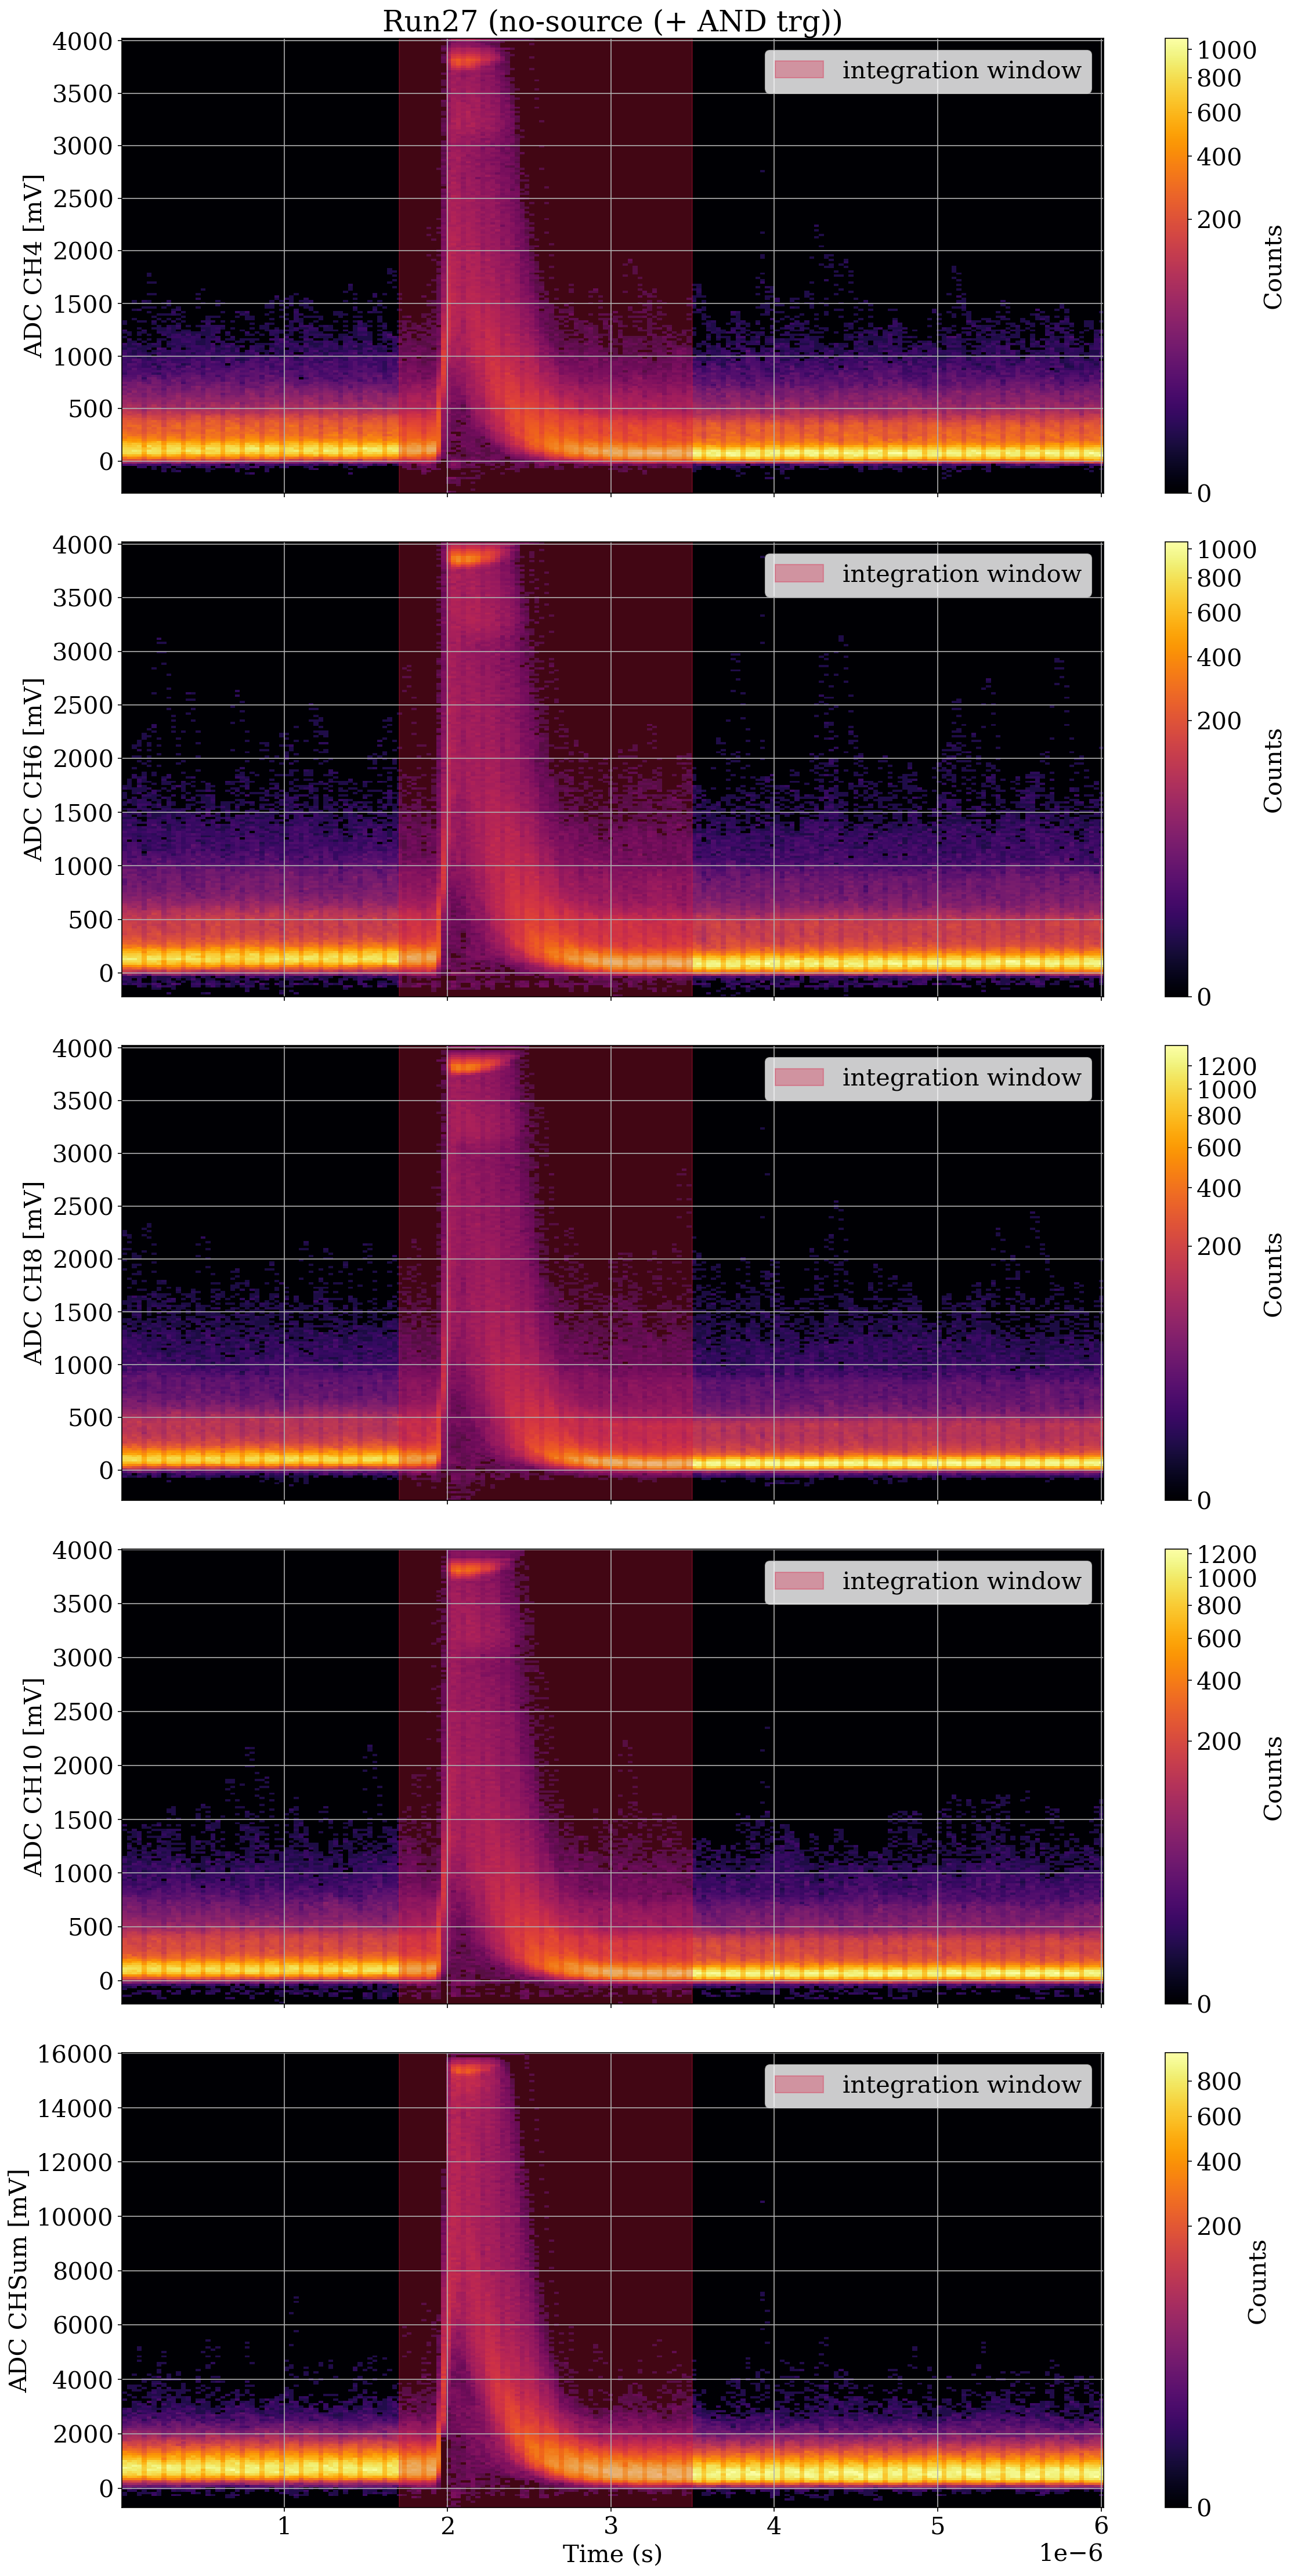

In [41]:
# Create subplots: 2 rows, 1 column

if len(channels) > 1:
    fig, axs = plt.subplots(len(channels), 1, figsize=(16, len(channels)*6), dpi=150, sharex=True)
else:
    fig, ax = plt.subplots(1, 1, figsize=(16, 6), dpi=150, sharex=True)

if len(channels) > 1:
    axs[0].set_title(f"{data_nosource['run']} ({data_nosource['source']})")
else:
    ax.set_title(f"{data_nosource['run']} ({data_nosource['source']})")


# Plot CHs
for i in range(len(channels)):

    if len(channels) > 1:
        ax = axs[i]

    voltage  = final_df_nosource[f'{channels[i]}'].values
    v_matrix = voltage.reshape(nevents_nosource, -1)
    # v_matrix_corrected, baselines, window = cig.BaselineCorrection(v_matrix, window=window_width)
    v_matrix_corrected = v_matrix
    
    # voltage_matrix = np.array([...]) # shape (nevents, nsamples)
    hb = ax.hist2d(t_matrix_nosource.flatten(), v_matrix_corrected.flatten(), bins=[200, 200], 
                   cmap='inferno', norm=mcolors.PowerNorm(gamma=0.3))

    fig.colorbar(hb[3], ax=ax, label="Counts")

    ax.fill_between(time_nosource[time_window_nosource], v_matrix_corrected.min(), v_matrix_corrected.max(), 
                    color = colors[1], alpha = 0.3, label = 'integration window')

    ax.set_ylabel(f'ADC {channels[i]} [mV]')
    ax.grid(True)
    ax.legend()

if len(channels) > 1:
    axs[-1].set_xlabel('Time (s)')
else:
    ax.set_xlabel('Time (s)')

# plt.xlim(-2e-7,40e-7)

# Improve layout
plt.tight_layout()
plt.show()

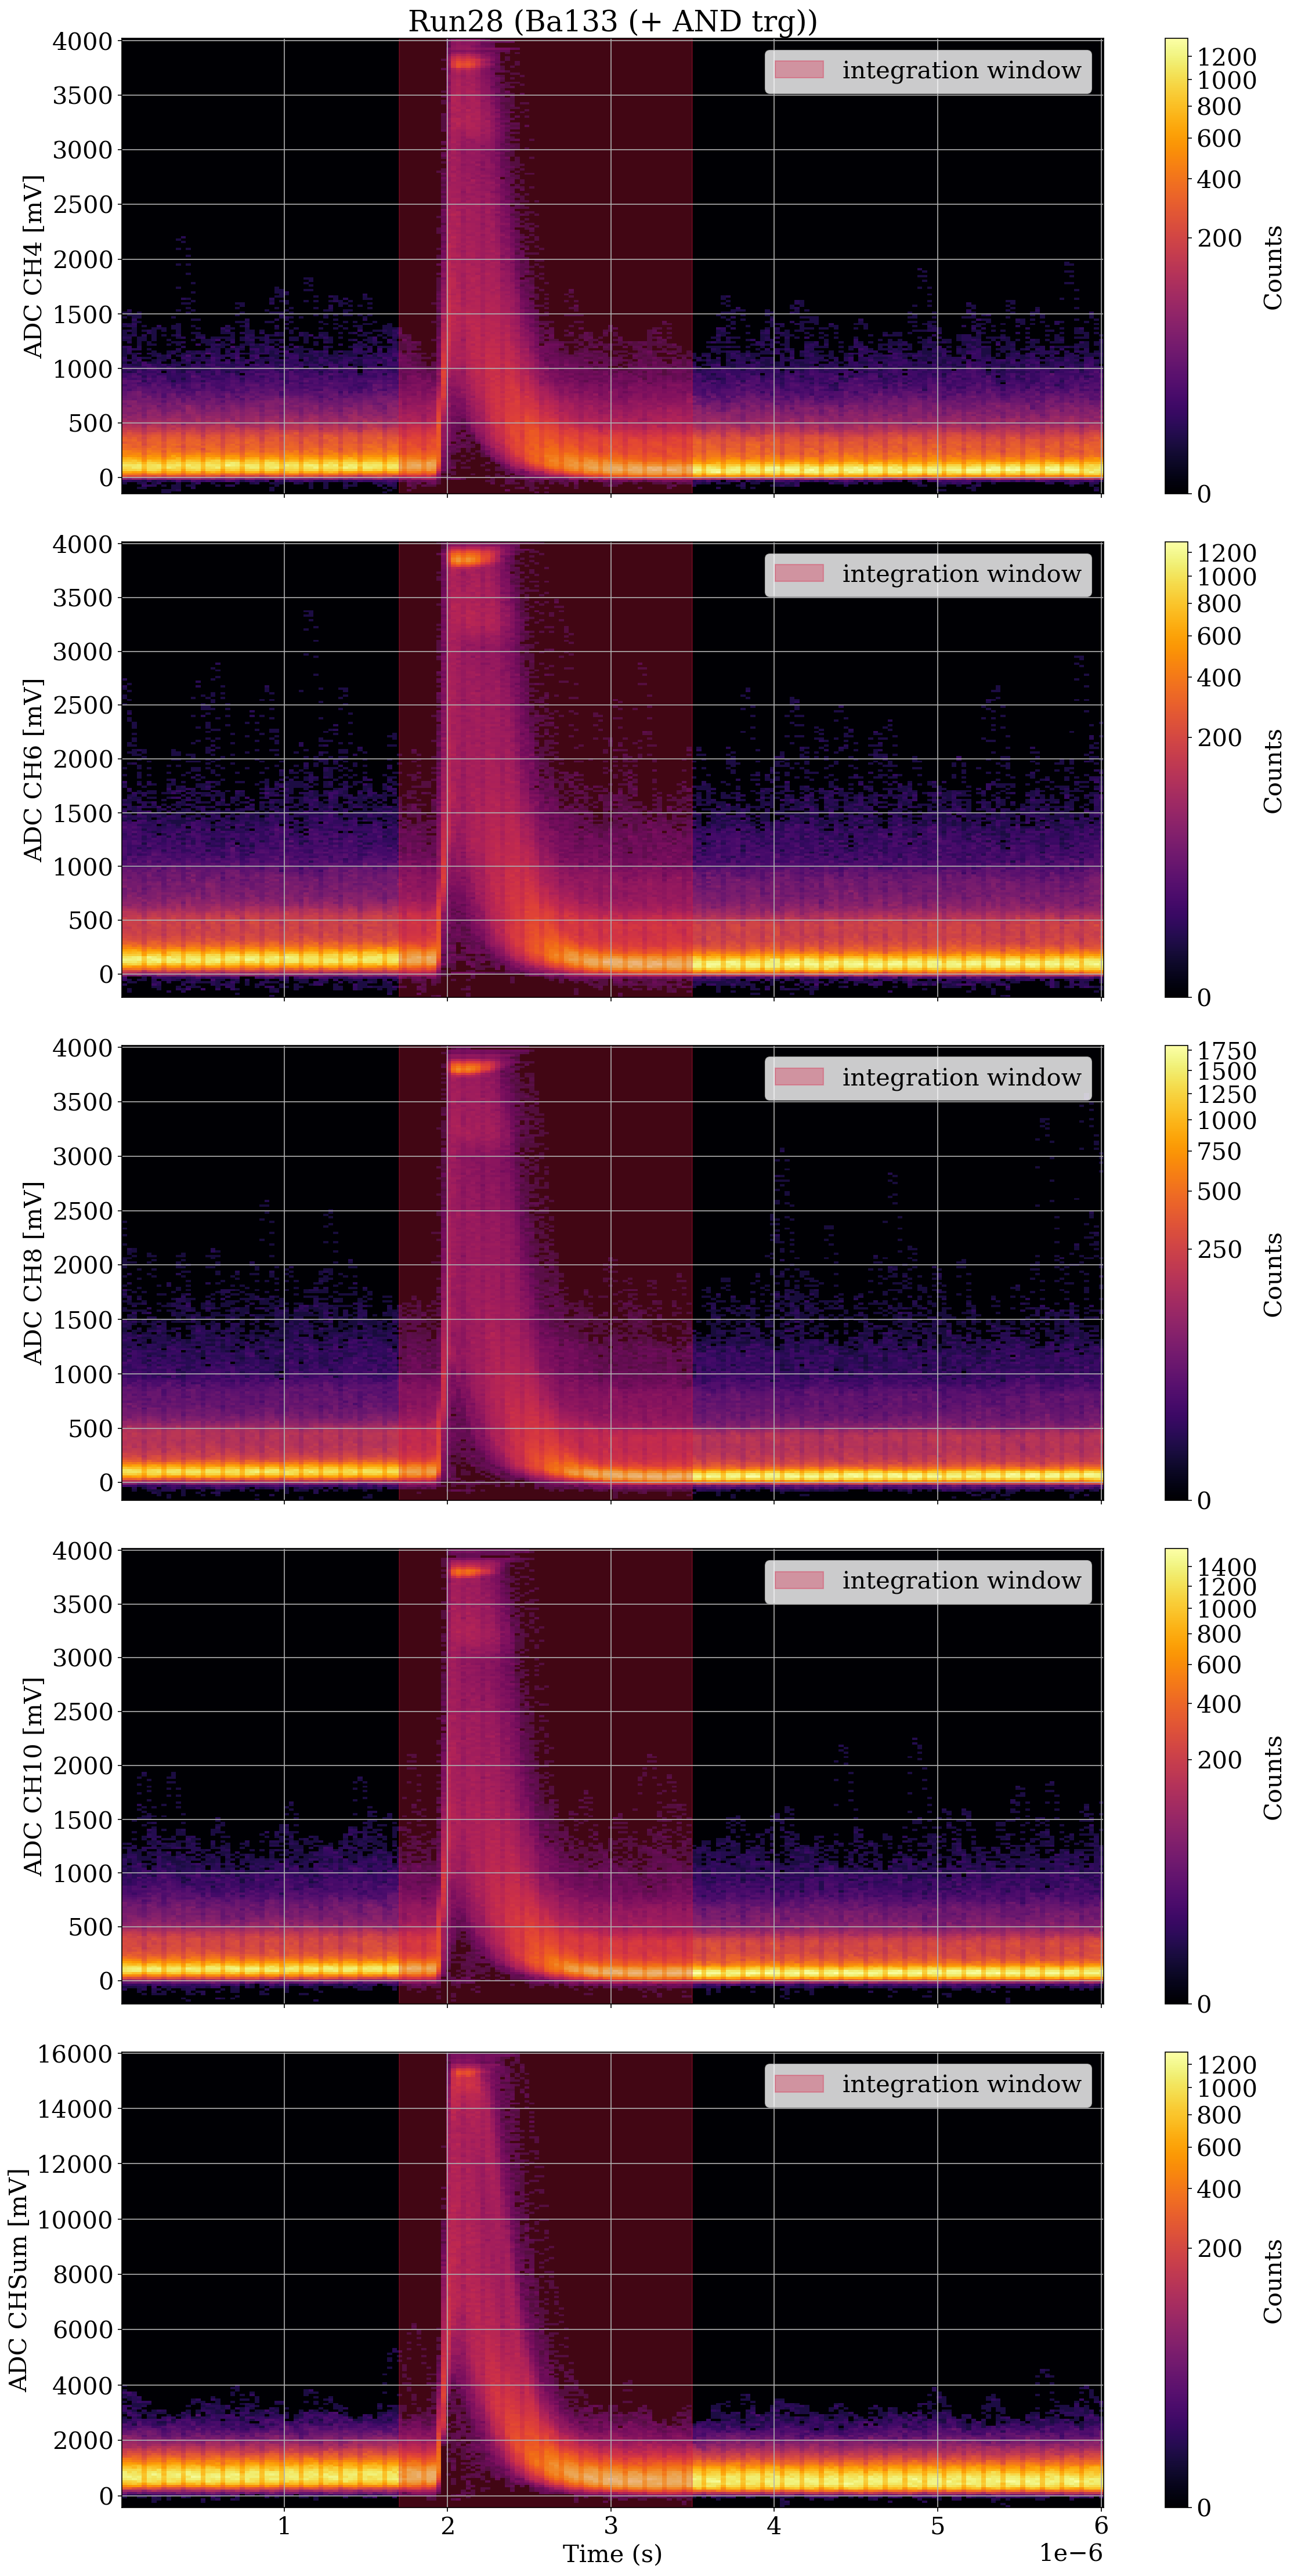

In [42]:
# Create subplots: 2 rows, 1 column

if len(channels) > 1:
    fig, axs = plt.subplots(len(channels), 1, figsize=(16, len(channels)*6), dpi=150, sharex=True)
else:
    fig, ax = plt.subplots(1, 1, figsize=(16, 6), dpi=150, sharex=True)

if len(channels) > 1:
    axs[0].set_title(f"{data_source['run']} ({data_source['source']})")
else:
    ax.set_title(f"{data_source['run']} ({data_source['source']})")


# Plot CHs
for i in range(len(channels)):

    if len(channels) > 1:
        ax = axs[i]

    voltage  = final_df_source[f'{channels[i]}'].values
    v_matrix = voltage.reshape(nevents_source, -1)
    # v_matrix_corrected, baselines, window = cig.BaselineCorrection(v_matrix, window=window_width)
    v_matrix_corrected = v_matrix
    
    # voltage_matrix = np.array([...]) # shape (nevents, nsamples)
    hb = ax.hist2d(t_matrix_source.flatten(), v_matrix_corrected.flatten(), bins=[200, 200], 
                   cmap='inferno', norm=mcolors.PowerNorm(gamma=0.3))

    fig.colorbar(hb[3], ax=ax, label="Counts")

    ax.fill_between(time_source[time_window_source], v_matrix_corrected.min(), v_matrix_corrected.max(), 
                    color = colors[1], alpha = 0.3, label = 'integration window')

    ax.set_ylabel(f'ADC {channels[i]} [mV]')
    ax.grid(True)
    ax.legend()

if len(channels) > 1:
    axs[-1].set_xlabel('Time (s)')
else:
    ax.set_xlabel('Time (s)')

# plt.xlim(-2e-7,40e-7)

# Improve layout
plt.tight_layout()
plt.show()

Run27 is 33.74 mins long
Run28 is 7.98 mins long


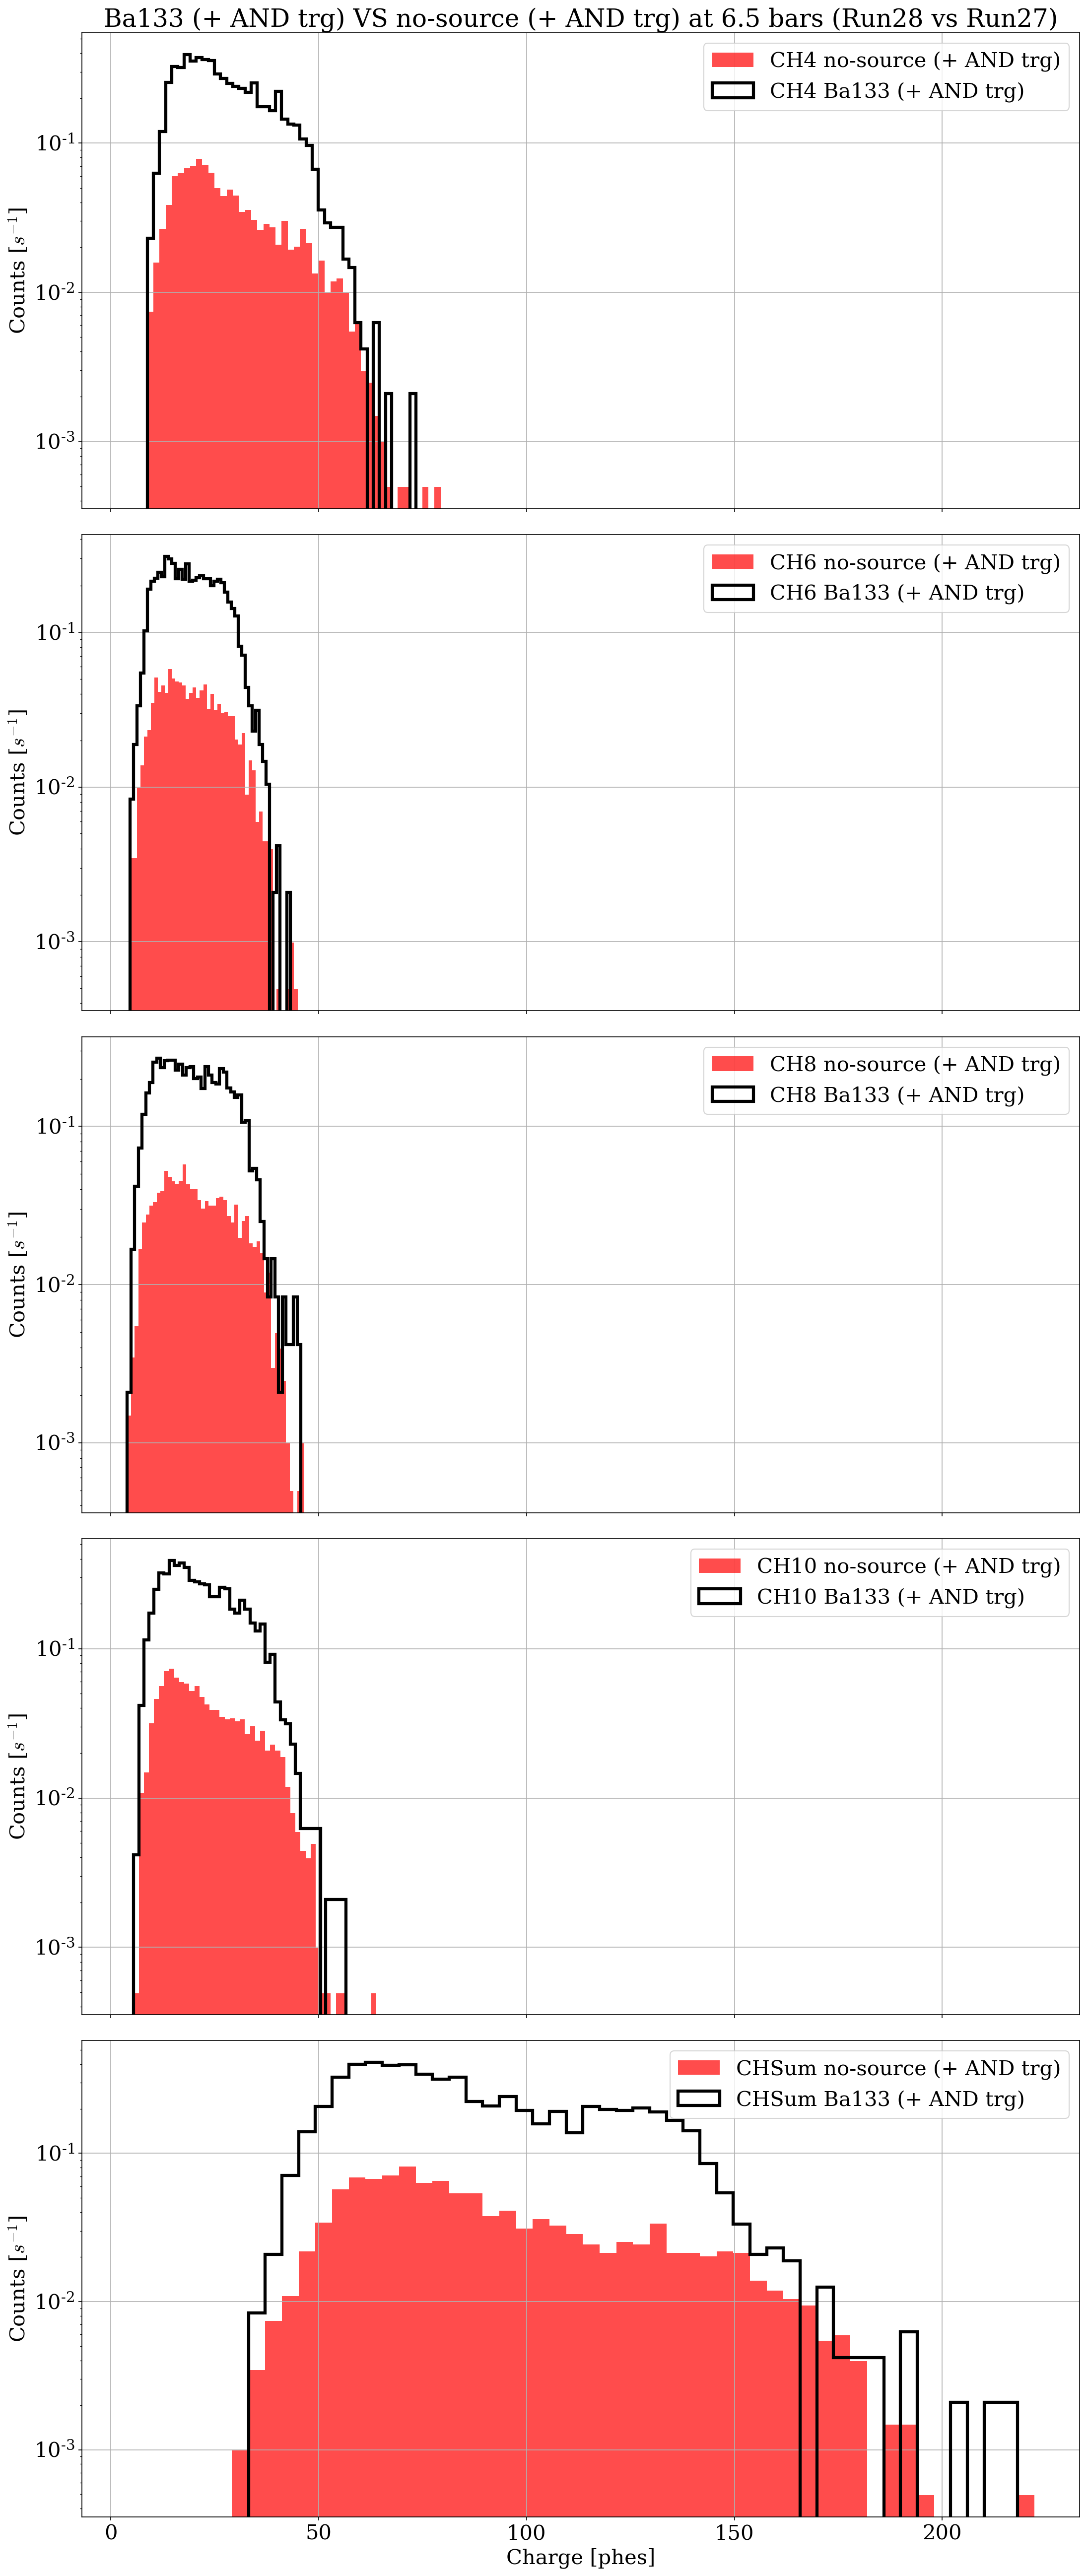

In [43]:
# Create subplots: 2 rows, 1 column

if len(channels) > 1:
    fig, axs = plt.subplots(len(channels), 1, figsize=(15, len(channels)*7), dpi=150, sharex=True)
else:
    fig, ax = plt.subplots(1, 1, figsize=(15, 7), dpi=150, sharex=True)

if len(channels) > 1:
    axs[0].set_title(f"{data_source['source']} VS {data_nosource['source']} at {pressure} bars ({data_source['run']} vs {data_nosource['run']})")
else:
    ax.set_title(f"{data_source['source']} VS {data_nosource['source']} at {pressure} bars ({data_source['run']} vs {data_nosource['run']})")

charge_nosource_Sum = 0
charge_source_Sum   = 0

run_duration_nosource   = ((final_df_nosource.groupby('file_idx').max().event_time - final_df_nosource.groupby('file_idx').min().event_time)*8e-9).sum()
print(f"{data_nosource['run']} is {run_duration_nosource/60:.2f} mins long")
run_duration_source     = ((final_df_source.groupby('file_idx').max().event_time - final_df_source.groupby('file_idx').min().event_time)*8e-9).sum()
print(f"{data_source['run']} is {run_duration_source/60:.2f} mins long")


# Plot CHs
for i, ch in enumerate(channels):

    if len(channels) > 1:
        ax = axs[i]
    
    # NO SOURCE -------------------------------------------------------------------------
    voltage_nosource = final_df_nosource[f'{channels[i]}'].values

    v_matrix_nosource                    = voltage_nosource.reshape(nevents_nosource, -1)
    # v_matrix_corrected_nosource, _, _    = cig.BaselineCorrection(v_matrix_nosource, window=window_width)
    v_matrix_corrected_nosource = v_matrix_nosource

    charge_nosource = np.trapz(v_matrix_corrected_nosource[:, time_window_nosource]*1e-3,
                      x = time_nosource[time_window_nosource]
                      ,axis = 1)
    
    if data_nosource['pes']:
        if ch != 'CHSum':
            charge_nosource = cig.ChargeToPes(charge_nosource, channel=i+1, 
                                        temp = data_nosource['temperature'], amplified = data_nosource['is_amplified'], CHAmp=data_nosource['amp_factors'])
            charge_nosource_Sum = charge_nosource_Sum + charge_nosource
        else:
            charge_nosource = charge_nosource_Sum


    events_nosource, bins, image = ax.hist(charge_nosource
                                ,bins = int(np.sqrt(len(charge_nosource))) 
                                ,weights=np.ones_like(charge_nosource)/run_duration_nosource
                                # ,range = (0, 400)
                                ,density = False
                                ,histtype   ='stepfilled'
                                ,color      = 'r'
                                ,ls         = '-'
                                ,lw         = 3
                                ,alpha      = 0.7
                                ,label = f"{ch} {data_nosource['source']}"
                                )
    
    # SOURCE -------------------------------------------------------------------------
    voltage_source = final_df_source[f'{channels[i]}'].values

    v_matrix_source                    = voltage_source.reshape(nevents_source, -1)
    # v_matrix_corrected_source, _, _    = cig.BaselineCorrection(v_matrix_source, window=window_width)
    v_matrix_corrected_source = v_matrix_source

    charge_source = np.trapz(v_matrix_corrected_source[:, time_window_source]*1e-3,
                      x = time_source[time_window_source]
                      ,axis = 1)

    if data_source['pes']:
        if ch != 'CHSum':
            charge_source = cig.ChargeToPes(charge_source, channel=i+1, 
                                        temp = data_source['temperature'], amplified = data_source['is_amplified'], CHAmp=data_source['amp_factors'])
            charge_source_Sum = charge_source_Sum + charge_source
        else:
            charge_source = charge_source_Sum

    events_source, bins, image = ax.hist(charge_source
                                ,bins = bins
                                ,weights=np.ones_like(charge_source)/run_duration_source
                                ,density = False
                                ,histtype   ='step'
                                ,color      = 'k'
                                ,ls         = '-'
                                ,lw         = 3
                                ,alpha      = 1
                                ,label = f"{ch} {data_source['source']}"
                                )
    
    ax.set_ylabel(fr'Counts [$s^{{-1}}$]')
    ax.grid(True)
    ax.set_yscale('log')
    ax.legend()

if len(channels) > 1:
    if pes:
        axs[-1].set_xlabel(r'Charge [phes]')
    else:
        axs[-1].set_xlabel(r'Charge [V $\cdot$ s]')
else:
    ax.set_xlabel(r'Charge [V $\cdot$ s]')

# plt.xlim(0.5, 550)

# Improve layout
plt.tight_layout()
plt.show()

In [44]:
charge_nosource.min()

29.097642645236032

In [45]:
bins

array([ 29.09764265,  33.11897472,  37.14030679,  41.16163886,
        45.18297094,  49.20430301,  53.22563508,  57.24696716,
        61.26829923,  65.2896313 ,  69.31096337,  73.33229545,
        77.35362752,  81.37495959,  85.39629167,  89.41762374,
        93.43895581,  97.46028789, 101.48161996, 105.50295203,
       109.5242841 , 113.54561618, 117.56694825, 121.58828032,
       125.6096124 , 129.63094447, 133.65227654, 137.67360861,
       141.69494069, 145.71627276, 149.73760483, 153.75893691,
       157.78026898, 161.80160105, 165.82293313, 169.8442652 ,
       173.86559727, 177.88692934, 181.90826142, 185.92959349,
       189.95092556, 193.97225764, 197.99358971, 202.01492178,
       206.03625385, 210.05758593, 214.078918  , 218.10025007,
       222.12158215])

In [46]:
events_source.sum(), events_nosource.sum()

(6.290892874584854, 1.1662095949413032)

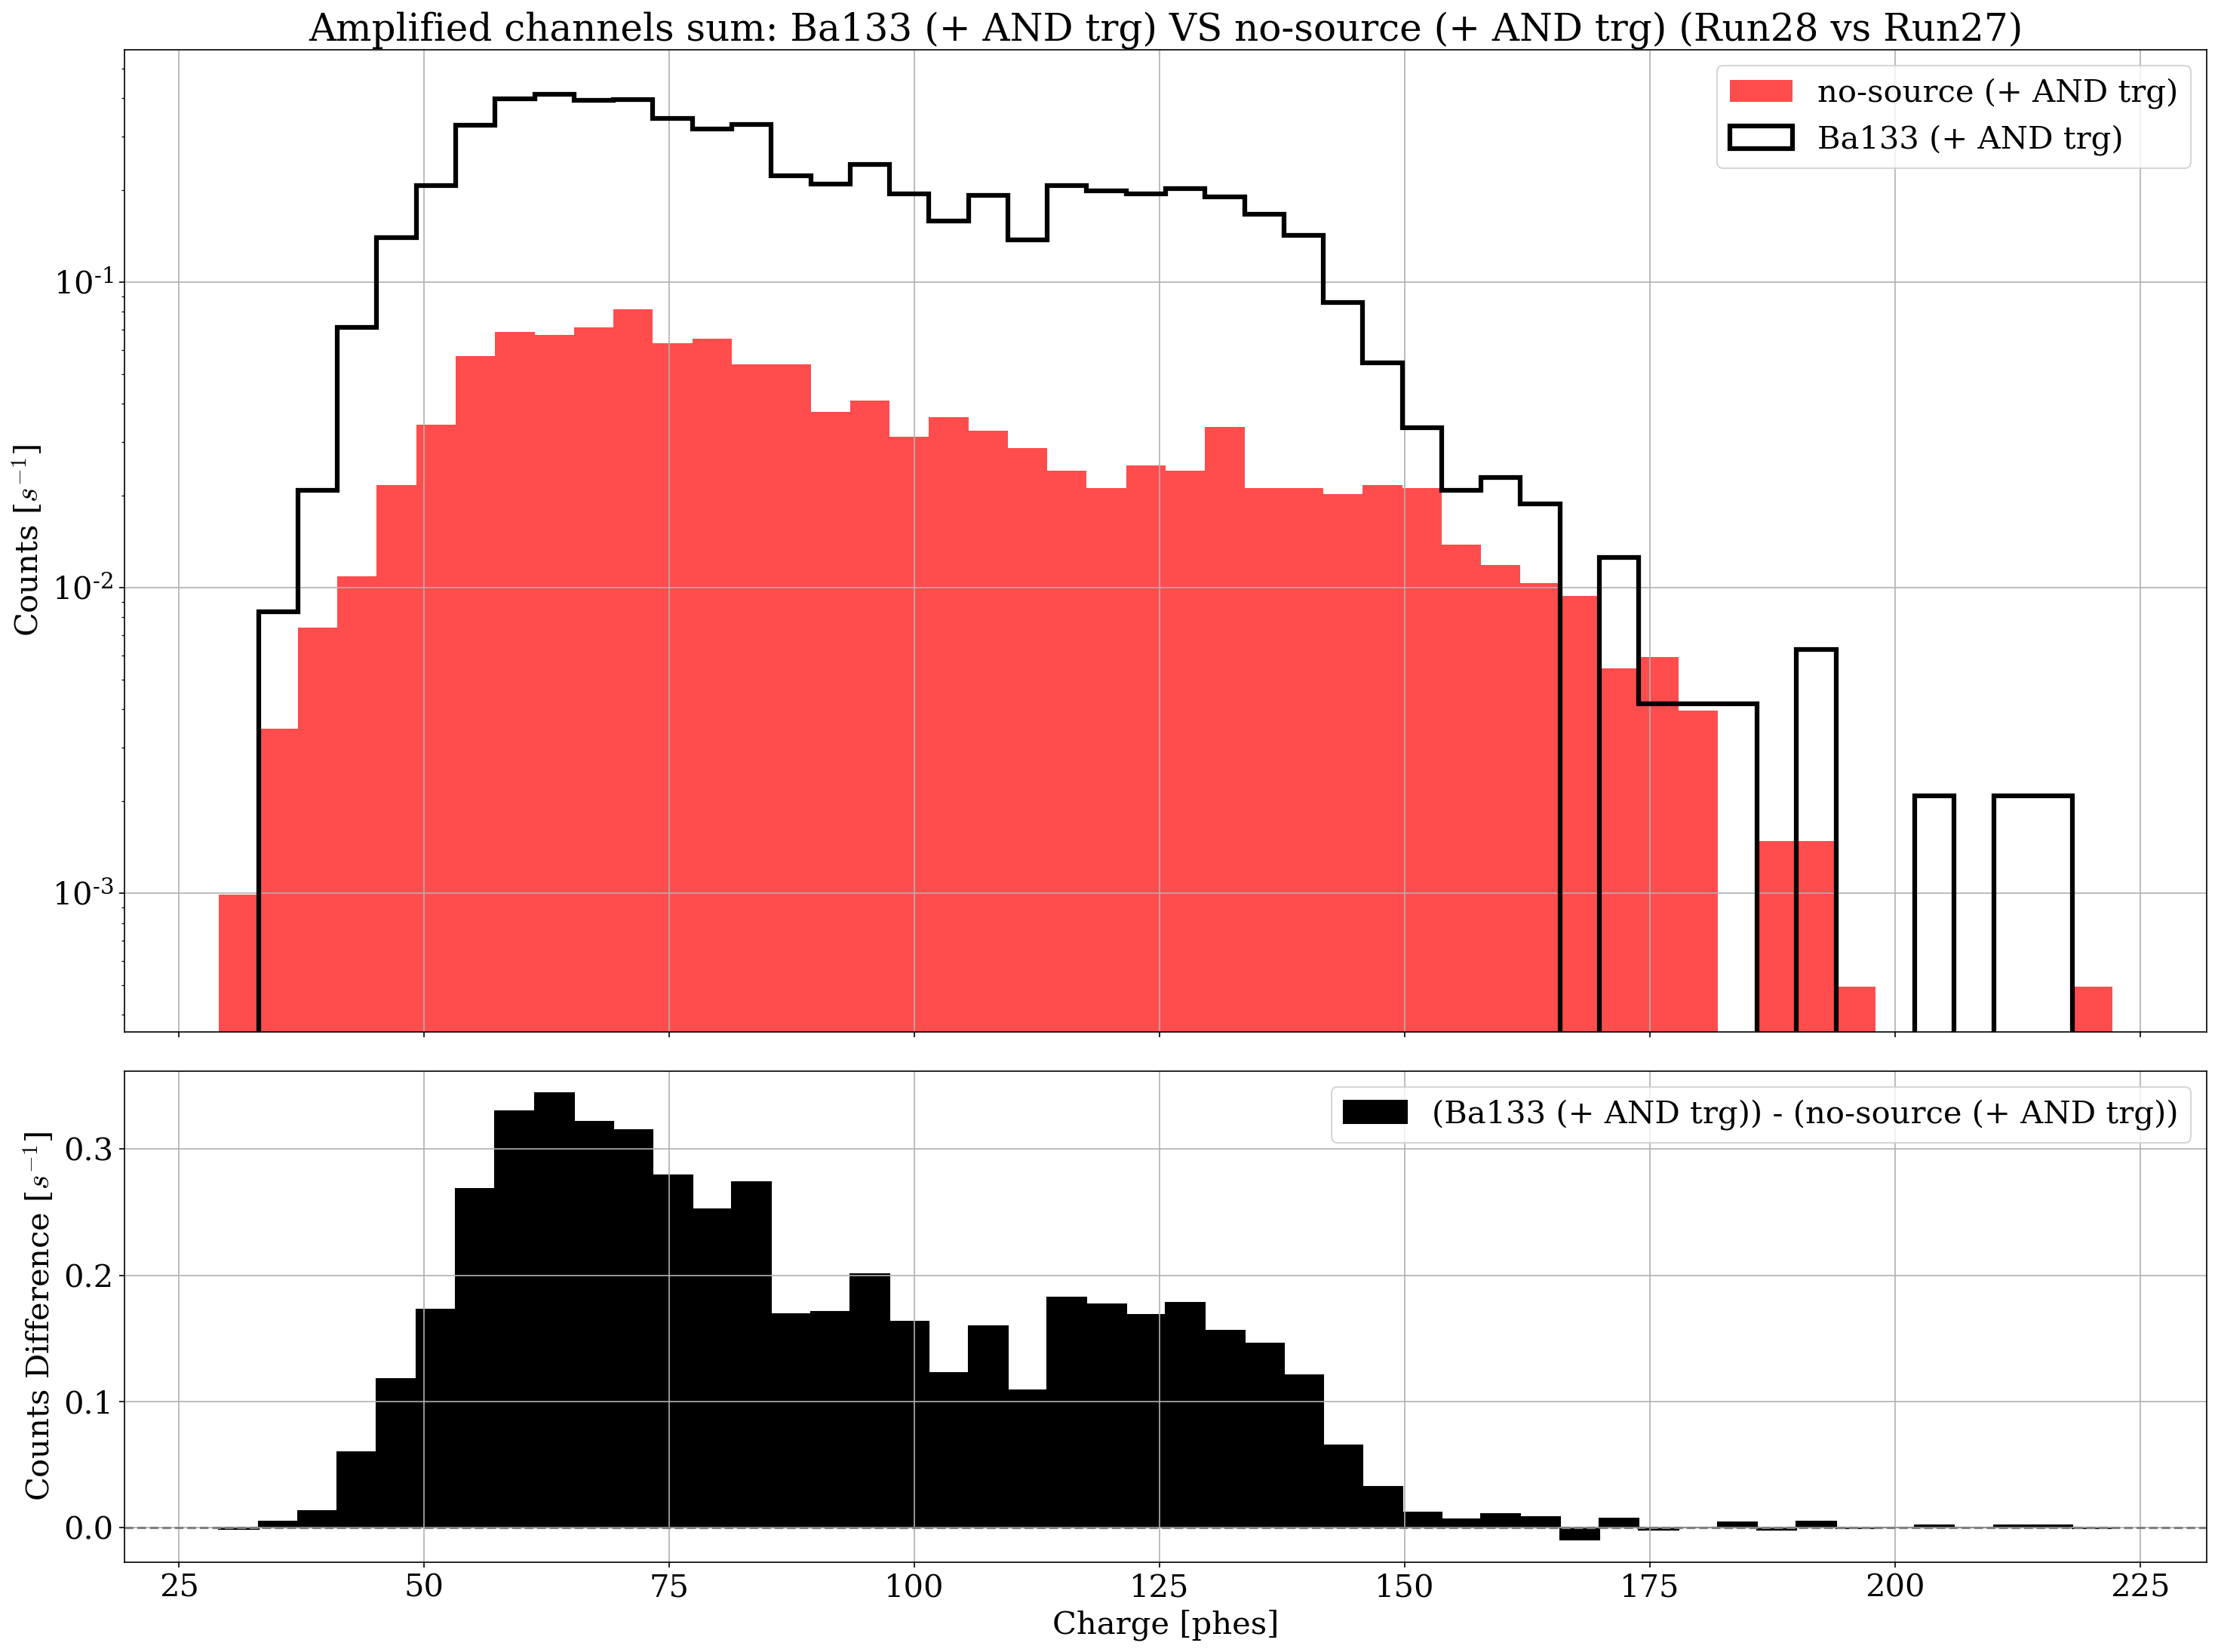

In [ ]:
# Create GridSpec with two rows, one smaller
fig, axs = plt.subplots(2, 1,
                        figsize=(20, 15),
                        dpi=150,
                        sharex=True,
                        gridspec_kw={'height_ratios': [2, 1]}  # top subplot twice as tall
                        )

if amplified:
    axs[0].set_title(f"Amplified channels sum: {data_source['source']} VS {data_nosource['source']} ({data_source['run']} vs {data_nosource['run']})")
else:
    axs[0].set_title(f"Non-amplified channels sum: {data_source['source']} VS {data_nosource['source']} ({data_source['run']} vs {data_nosource['run']})")



# PLOT 1: Sum histograms
ax = axs[0]

events_nosource, bins, image = ax.hist(charge_nosource_Sum
                                        ,bins = bins
                                        ,weights=np.ones_like(charge_nosource_Sum)/run_duration_nosource
                                        ,density = False
                                        ,histtype   ='stepfilled'
                                        ,color      = 'r'
                                        ,ls         = '-'
                                        ,lw         = 3
                                        ,alpha      = 0.7
                                        ,label = f"{data_nosource['source']}"
                                        )


events_source, bins, image = ax.hist(charge_source_Sum
                                    ,bins = bins
                                    ,weights=np.ones_like(charge_source_Sum)/run_duration_source
                                    ,density = False
                                    ,histtype   ='step'
                                    ,color      = 'k'
                                    ,ls         = '-'
                                    ,lw         = 3
                                    ,alpha      = 1
                                    ,label = f"{data_source['source']}"
                                    )


ax.set_ylabel(fr'Counts [$s^{{-1}}$]')
ax.grid(True)
ax.set_yscale('log')
ax.legend()



# PLOT 2: Histograms difference
ax = axs[1]

bin_centers = (bins[1:] + bins[:-1])/2

events_difference = events_source - events_nosource

width = np.diff(bins)
ax.bar(bin_centers, events_difference, width=width, align='center',
       color='k', edgecolor='k', alpha=1, label=f"({data_source['source']}) - ({data_nosource['source']})")

ax.axhline(0, color='grey', linestyle='--')
ax.set_ylabel(fr'Counts Difference [$s^{{-1}}$]')
ax.set_yscale('linear')     # linear to show negatives
ax.grid(True)
ax.legend()

if pes:
    axs[-1].set_xlabel(r'Charge [phes]')
else:
    axs[-1].set_xlabel(r'Charge [V $\cdot$ s]')


# Improve layout
plt.tight_layout()
plt.show()